In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.9, 1.0),
        ratio=(0.95, 1.05)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"Tissue Types: {label_encoder.classes_}")
# Print encoding information

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [12]:
def create_deit_model(model_type='tiny', num_classes=4, pretrained=True):
    """
    Create DeiT (Data-efficient Image Transformer) model for bladder tissue classification
    
    Args:
        model_type (str): DeiT variant - 'tiny', 'small', or 'base'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: DeiT model
    """
    model = timm.create_model(
        f'deit_{model_type}_patch16_224',
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train DeiT Tiny

Training DeiT Tiny


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.12it/s, Loss=1.4026, Acc=0.3224]


Train Loss: 1.4026 Acc: 0.3224 Macro-F1: 0.2981


Val : 100%|██████████| 10/10 [00:01<00:00,  5.50it/s, Loss=1.2118, Acc=0.4836]


Val Loss: 1.2118 Acc: 0.4836 Macro-F1: 0.3490
✓ New best model saved with validation macro-F1: 0.3490

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.03it/s, Loss=1.1980, Acc=0.4309]


Train Loss: 1.1980 Acc: 0.4309 Macro-F1: 0.3984


Val : 100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Loss=1.2972, Acc=0.4803]


Val Loss: 1.2972 Acc: 0.4803 Macro-F1: 0.3963
✓ New best model saved with validation macro-F1: 0.3963

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.11it/s, Loss=1.1908, Acc=0.4531]


Train Loss: 1.1908 Acc: 0.4531 Macro-F1: 0.4131


Val : 100%|██████████| 10/10 [00:01<00:00,  9.29it/s, Loss=1.2719, Acc=0.4211]


Val Loss: 1.2719 Acc: 0.4211 Macro-F1: 0.3665

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.21it/s, Loss=1.1441, Acc=0.4992]


Train Loss: 1.1441 Acc: 0.4992 Macro-F1: 0.4603


Val : 100%|██████████| 10/10 [00:00<00:00, 10.33it/s, Loss=1.0081, Acc=0.5362]


Val Loss: 1.0081 Acc: 0.5362 Macro-F1: 0.4908
✓ New best model saved with validation macro-F1: 0.4908

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.13it/s, Loss=0.9438, Acc=0.5880]


Train Loss: 0.9438 Acc: 0.5880 Macro-F1: 0.5592


Val : 100%|██████████| 10/10 [00:00<00:00, 10.33it/s, Loss=0.9148, Acc=0.6118]


Val Loss: 0.9148 Acc: 0.6118 Macro-F1: 0.5146
✓ New best model saved with validation macro-F1: 0.5146

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.06it/s, Loss=0.9290, Acc=0.6283]


Train Loss: 0.9290 Acc: 0.6283 Macro-F1: 0.5884


Val : 100%|██████████| 10/10 [00:00<00:00, 10.43it/s, Loss=0.9288, Acc=0.6645]


Val Loss: 0.9288 Acc: 0.6645 Macro-F1: 0.6165
✓ New best model saved with validation macro-F1: 0.6165

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.25it/s, Loss=1.0015, Acc=0.5979]


Train Loss: 1.0015 Acc: 0.5979 Macro-F1: 0.5424


Val : 100%|██████████| 10/10 [00:00<00:00, 10.29it/s, Loss=0.9374, Acc=0.6513]


Val Loss: 0.9374 Acc: 0.6513 Macro-F1: 0.6134

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.12it/s, Loss=0.7970, Acc=0.7163]


Train Loss: 0.7970 Acc: 0.7163 Macro-F1: 0.6683


Val : 100%|██████████| 10/10 [00:00<00:00, 10.46it/s, Loss=0.6151, Acc=0.7993]


Val Loss: 0.6151 Acc: 0.7993 Macro-F1: 0.7595
✓ New best model saved with validation macro-F1: 0.7595

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.04it/s, Loss=0.6369, Acc=0.7845]


Train Loss: 0.6369 Acc: 0.7845 Macro-F1: 0.7409


Val : 100%|██████████| 10/10 [00:01<00:00,  9.94it/s, Loss=0.5098, Acc=0.8224]


Val Loss: 0.5098 Acc: 0.8224 Macro-F1: 0.7812
✓ New best model saved with validation macro-F1: 0.7812

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.06it/s, Loss=0.5358, Acc=0.8224]


Train Loss: 0.5358 Acc: 0.8224 Macro-F1: 0.7884


Val : 100%|██████████| 10/10 [00:00<00:00, 10.18it/s, Loss=0.5208, Acc=0.7961]


Val Loss: 0.5208 Acc: 0.7961 Macro-F1: 0.7606

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.19it/s, Loss=0.4849, Acc=0.8388]


Train Loss: 0.4849 Acc: 0.8388 Macro-F1: 0.8100


Val : 100%|██████████| 10/10 [00:00<00:00, 10.45it/s, Loss=0.4316, Acc=0.8289]


Val Loss: 0.4316 Acc: 0.8289 Macro-F1: 0.7837
✓ New best model saved with validation macro-F1: 0.7837

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.16it/s, Loss=0.4221, Acc=0.8660]


Train Loss: 0.4221 Acc: 0.8660 Macro-F1: 0.8330


Val : 100%|██████████| 10/10 [00:00<00:00, 10.12it/s, Loss=0.3091, Acc=0.8684]


Val Loss: 0.3091 Acc: 0.8684 Macro-F1: 0.8424
✓ New best model saved with validation macro-F1: 0.8424

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.09it/s, Loss=0.3352, Acc=0.8734]


Train Loss: 0.3352 Acc: 0.8734 Macro-F1: 0.8501


Val : 100%|██████████| 10/10 [00:00<00:00, 10.37it/s, Loss=0.3202, Acc=0.8750]


Val Loss: 0.3202 Acc: 0.8750 Macro-F1: 0.8368

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.30it/s, Loss=0.3636, Acc=0.8799]


Train Loss: 0.3636 Acc: 0.8799 Macro-F1: 0.8516


Val : 100%|██████████| 10/10 [00:01<00:00,  9.80it/s, Loss=0.2919, Acc=0.9046]


Val Loss: 0.2919 Acc: 0.9046 Macro-F1: 0.8902
✓ New best model saved with validation macro-F1: 0.8902

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.17it/s, Loss=0.2818, Acc=0.9038]


Train Loss: 0.2818 Acc: 0.9038 Macro-F1: 0.8919


Val : 100%|██████████| 10/10 [00:00<00:00, 10.30it/s, Loss=0.2698, Acc=0.9112]


Val Loss: 0.2698 Acc: 0.9112 Macro-F1: 0.9014
✓ New best model saved with validation macro-F1: 0.9014

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.17it/s, Loss=0.2628, Acc=0.9137]


Train Loss: 0.2628 Acc: 0.9137 Macro-F1: 0.9009


Val : 100%|██████████| 10/10 [00:00<00:00, 10.41it/s, Loss=0.2699, Acc=0.9079]


Val Loss: 0.2699 Acc: 0.9079 Macro-F1: 0.8955

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.23it/s, Loss=0.2554, Acc=0.9137]


Train Loss: 0.2554 Acc: 0.9137 Macro-F1: 0.9028


Val : 100%|██████████| 10/10 [00:00<00:00, 10.40it/s, Loss=0.2890, Acc=0.9046]


Val Loss: 0.2890 Acc: 0.9046 Macro-F1: 0.8898

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.29it/s, Loss=0.2767, Acc=0.9030]


Train Loss: 0.2767 Acc: 0.9030 Macro-F1: 0.8830


Val : 100%|██████████| 10/10 [00:00<00:00, 10.37it/s, Loss=0.2685, Acc=0.9145]


Val Loss: 0.2685 Acc: 0.9145 Macro-F1: 0.9007

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  5.94it/s, Loss=0.2392, Acc=0.9112]


Train Loss: 0.2392 Acc: 0.9112 Macro-F1: 0.8959


Val : 100%|██████████| 10/10 [00:00<00:00, 10.37it/s, Loss=0.2400, Acc=0.9211]


Val Loss: 0.2400 Acc: 0.9211 Macro-F1: 0.9136
✓ New best model saved with validation macro-F1: 0.9136

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.11it/s, Loss=0.2267, Acc=0.9194]


Train Loss: 0.2267 Acc: 0.9194 Macro-F1: 0.9104


Val : 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Loss=0.2410, Acc=0.9211]


Val Loss: 0.2410 Acc: 0.9211 Macro-F1: 0.9099

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.22it/s, Loss=0.2231, Acc=0.9219]


Train Loss: 0.2231 Acc: 0.9219 Macro-F1: 0.9078


Val : 100%|██████████| 10/10 [00:01<00:00,  9.37it/s, Loss=0.2302, Acc=0.9309]


Val Loss: 0.2302 Acc: 0.9309 Macro-F1: 0.9216
✓ New best model saved with validation macro-F1: 0.9216

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.29it/s, Loss=0.2442, Acc=0.9145]


Train Loss: 0.2442 Acc: 0.9145 Macro-F1: 0.9040


Val : 100%|██████████| 10/10 [00:00<00:00, 10.13it/s, Loss=0.2298, Acc=0.9309]


Val Loss: 0.2298 Acc: 0.9309 Macro-F1: 0.9216

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.17it/s, Loss=0.2336, Acc=0.9317]


Train Loss: 0.2336 Acc: 0.9317 Macro-F1: 0.9197


Val : 100%|██████████| 10/10 [00:00<00:00, 10.18it/s, Loss=0.2312, Acc=0.9276]


Val Loss: 0.2312 Acc: 0.9276 Macro-F1: 0.9191

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.13it/s, Loss=0.2303, Acc=0.9285]


Train Loss: 0.2303 Acc: 0.9285 Macro-F1: 0.9238


Val : 100%|██████████| 10/10 [00:00<00:00, 10.30it/s, Loss=0.2304, Acc=0.9276]


Val Loss: 0.2304 Acc: 0.9276 Macro-F1: 0.9191

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:06<00:00,  6.31it/s, Loss=0.2281, Acc=0.9268]


Train Loss: 0.2281 Acc: 0.9268 Macro-F1: 0.9147


Val : 100%|██████████| 10/10 [00:00<00:00, 10.56it/s, Loss=0.2301, Acc=0.9243]


Val Loss: 0.2301 Acc: 0.9243 Macro-F1: 0.9125

Training complete in 3m 2s
Best validation macro-F1: 0.9216
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


Test Accuracy: 35.45%
Test Loss: 2.3427

Classification Report:
              precision    recall  f1-score   support

         HGC       0.56      0.38      0.45        74
         LGC       0.21      0.09      0.13        53
         NST       0.40      0.62      0.48        37
         NTL       0.19      0.44      0.27        25

    accuracy                           0.35       189
   macro avg       0.34      0.38      0.33       189
weighted avg       0.38      0.35      0.34       189


Confusion Matrix:
[[28 11 25 10]
 [19  5  1 28]
 [ 2  4 23  8]
 [ 1  4  9 11]]

ROC-AUC Scores:
Macro-average AUC: 0.6327
Micro-average AUC: 0.6234
HGC AUC: 0.7403
LGC AUC: 0.3460
NST AUC: 0.7717
NTL AUC: 0.6727


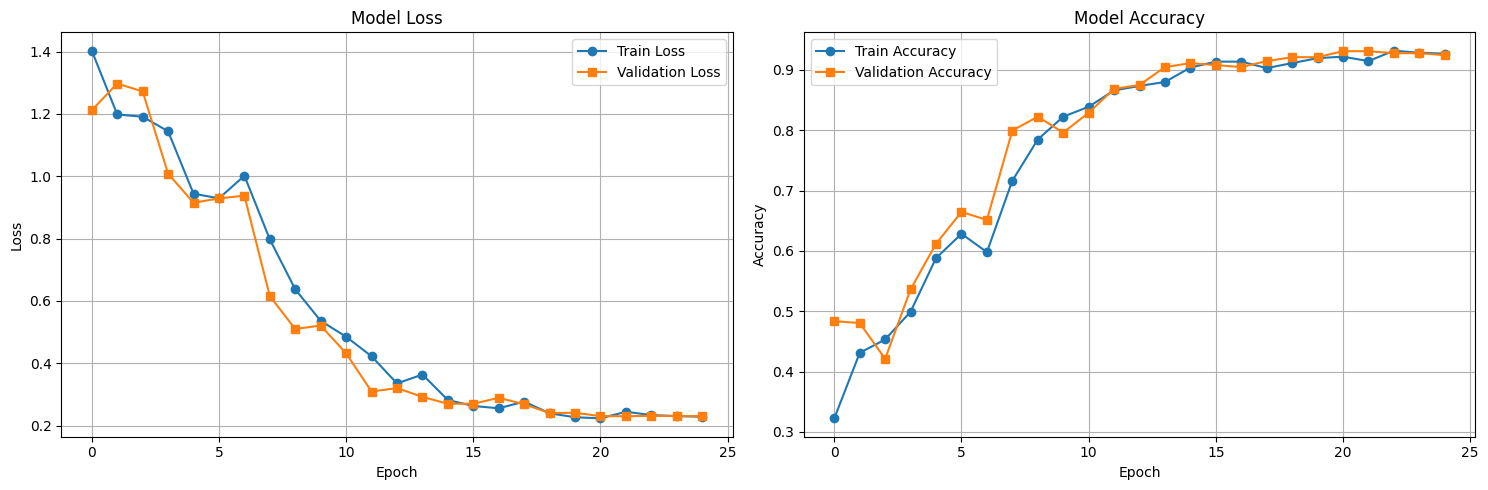

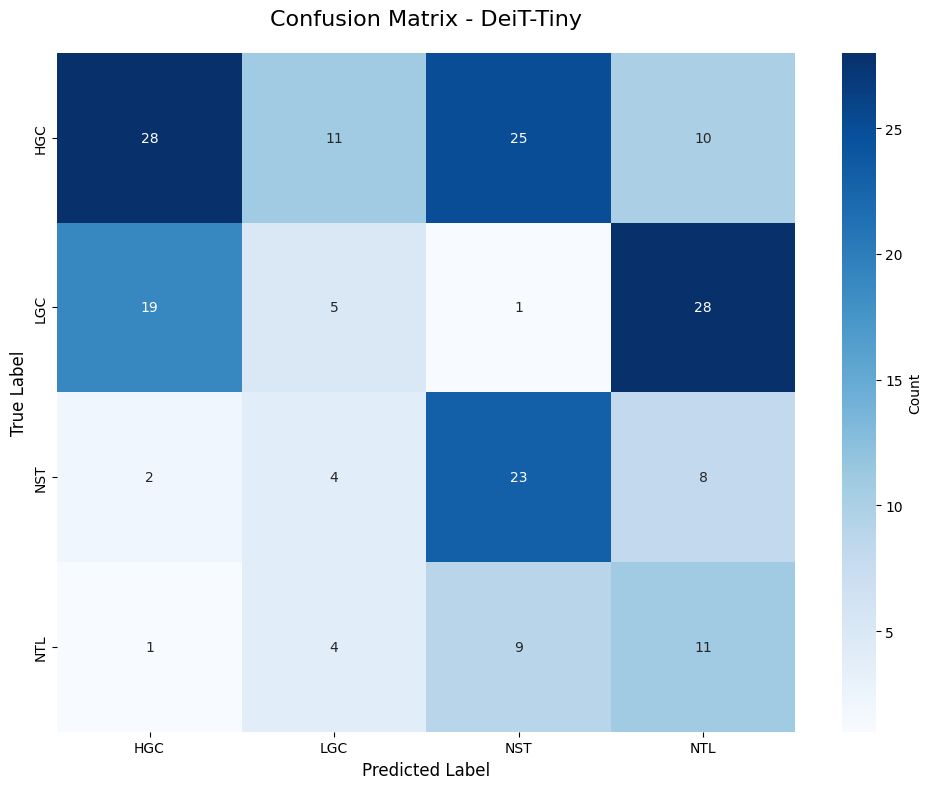

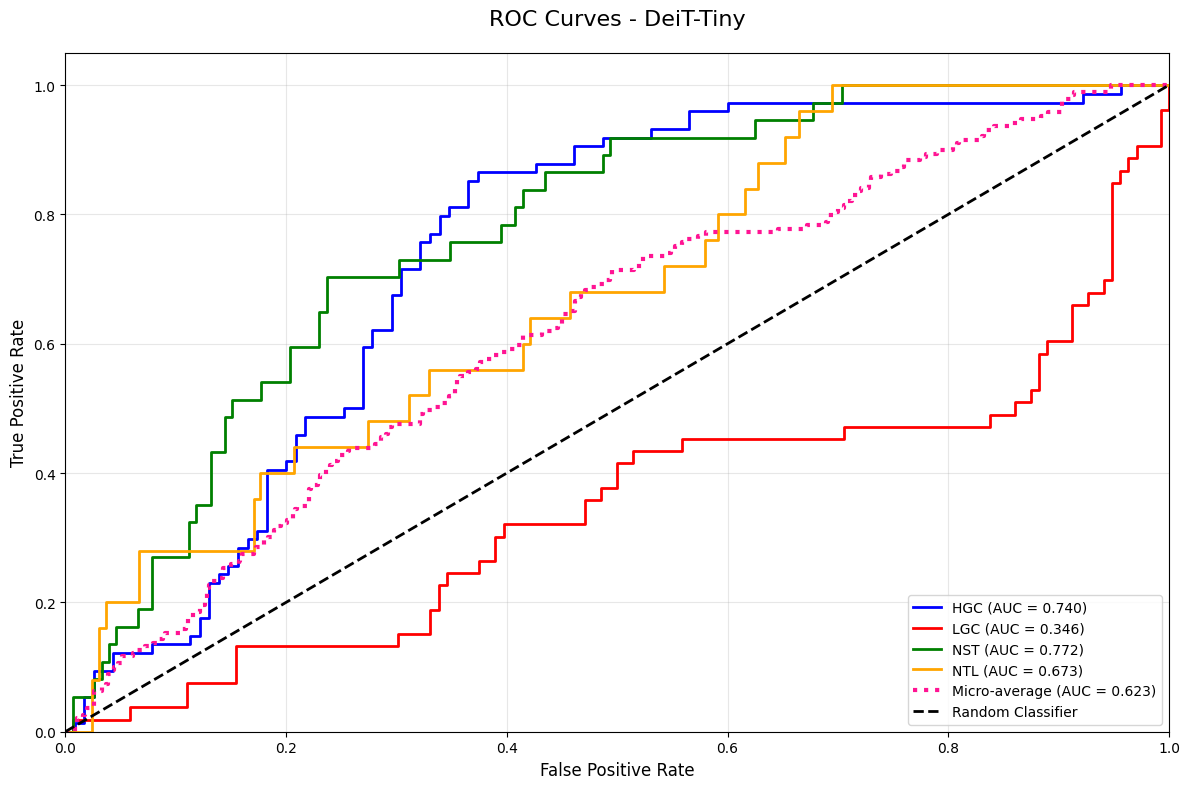


DeiT-Tiny training and evaluation complete!


In [16]:
print("="  * 80)
print("Training DeiT Tiny")
print("=" * 80)

# Create model
deit_tiny = create_deit_model(model_type='tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_deit_tiny = ModelTrainer(deit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_tiny = trainer_deit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Tiny")

# Plot training history
trainer_deit_tiny.plot_training_history(save_path='deit_tiny_training_history.png')

# Evaluate model
results_deit_tiny = trainer_deit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_tiny['confusion_matrix'], class_names, 'DeiT-Tiny',
                      save_path='deit_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_tiny = plot_roc_curves(results_deit_tiny['labels'], results_deit_tiny['probabilities'], class_names, 'DeiT-Tiny',
                                     save_path='deit_tiny_roc_curves.png')

# Store results
results_deit_tiny['model_name'] = 'DeiT-Tiny'
results_deit_tiny['roc_auc'] = roc_auc_deit_tiny
all_results.append(results_deit_tiny)

print("\nDeiT-Tiny training and evaluation complete!")

Training DeiT Small


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.76it/s, Loss=1.4852, Acc=0.2821]


Train Loss: 1.4852 Acc: 0.2821 Macro-F1: 0.2607


Val : 100%|██████████| 10/10 [00:01<00:00,  8.71it/s, Loss=1.6541, Acc=0.0724]


Val Loss: 1.6541 Acc: 0.0724 Macro-F1: 0.0337
✓ New best model saved with validation macro-F1: 0.0337

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.77it/s, Loss=1.3602, Acc=0.3191]


Train Loss: 1.3602 Acc: 0.3191 Macro-F1: 0.2999


Val : 100%|██████████| 10/10 [00:01<00:00,  9.25it/s, Loss=1.1533, Acc=0.4375]


Val Loss: 1.1533 Acc: 0.4375 Macro-F1: 0.2860
✓ New best model saved with validation macro-F1: 0.2860

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.79it/s, Loss=1.2754, Acc=0.4194]


Train Loss: 1.2754 Acc: 0.4194 Macro-F1: 0.3680


Val : 100%|██████████| 10/10 [00:01<00:00,  9.27it/s, Loss=1.1534, Acc=0.4638]


Val Loss: 1.1534 Acc: 0.4638 Macro-F1: 0.3703
✓ New best model saved with validation macro-F1: 0.3703

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.76it/s, Loss=1.2782, Acc=0.3980]


Train Loss: 1.2782 Acc: 0.3980 Macro-F1: 0.3578


Val : 100%|██████████| 10/10 [00:01<00:00,  9.59it/s, Loss=1.1396, Acc=0.4704]


Val Loss: 1.1396 Acc: 0.4704 Macro-F1: 0.3940
✓ New best model saved with validation macro-F1: 0.3940

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.75it/s, Loss=1.1919, Acc=0.4622]


Train Loss: 1.1919 Acc: 0.4622 Macro-F1: 0.4167


Val : 100%|██████████| 10/10 [00:01<00:00,  9.62it/s, Loss=1.1564, Acc=0.4145]


Val Loss: 1.1564 Acc: 0.4145 Macro-F1: 0.3567

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=1.2068, Acc=0.4449]


Train Loss: 1.2068 Acc: 0.4449 Macro-F1: 0.4052


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=1.0643, Acc=0.5461]


Val Loss: 1.0643 Acc: 0.5461 Macro-F1: 0.4354
✓ New best model saved with validation macro-F1: 0.4354

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=1.1262, Acc=0.4868]


Train Loss: 1.1262 Acc: 0.4868 Macro-F1: 0.4552


Val : 100%|██████████| 10/10 [00:01<00:00,  9.22it/s, Loss=1.0172, Acc=0.6349]


Val Loss: 1.0172 Acc: 0.6349 Macro-F1: 0.5894
✓ New best model saved with validation macro-F1: 0.5894

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.9762, Acc=0.6077]


Train Loss: 0.9762 Acc: 0.6077 Macro-F1: 0.5694


Val : 100%|██████████| 10/10 [00:01<00:00,  9.11it/s, Loss=0.9156, Acc=0.6349]


Val Loss: 0.9156 Acc: 0.6349 Macro-F1: 0.5899
✓ New best model saved with validation macro-F1: 0.5899

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.9205, Acc=0.6398]


Train Loss: 0.9205 Acc: 0.6398 Macro-F1: 0.5895


Val : 100%|██████████| 10/10 [00:01<00:00,  8.88it/s, Loss=0.8944, Acc=0.6250]


Val Loss: 0.8944 Acc: 0.6250 Macro-F1: 0.5926
✓ New best model saved with validation macro-F1: 0.5926

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.79it/s, Loss=0.8743, Acc=0.6160]


Train Loss: 0.8743 Acc: 0.6160 Macro-F1: 0.5841


Val : 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Loss=0.8657, Acc=0.6283]


Val Loss: 0.8657 Acc: 0.6283 Macro-F1: 0.6024
✓ New best model saved with validation macro-F1: 0.6024

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.8476, Acc=0.6324]


Train Loss: 0.8476 Acc: 0.6324 Macro-F1: 0.6039


Val : 100%|██████████| 10/10 [00:01<00:00,  9.48it/s, Loss=0.7894, Acc=0.6875]


Val Loss: 0.7894 Acc: 0.6875 Macro-F1: 0.6509
✓ New best model saved with validation macro-F1: 0.6509

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.7477, Acc=0.6817]


Train Loss: 0.7477 Acc: 0.6817 Macro-F1: 0.6517


Val : 100%|██████████| 10/10 [00:01<00:00,  9.14it/s, Loss=0.7922, Acc=0.6645]


Val Loss: 0.7922 Acc: 0.6645 Macro-F1: 0.6128

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.7298, Acc=0.6826]


Train Loss: 0.7298 Acc: 0.6826 Macro-F1: 0.6485


Val : 100%|██████████| 10/10 [00:01<00:00,  8.85it/s, Loss=0.7602, Acc=0.6743]


Val Loss: 0.7602 Acc: 0.6743 Macro-F1: 0.6371

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.79it/s, Loss=0.6414, Acc=0.7327]


Train Loss: 0.6414 Acc: 0.7327 Macro-F1: 0.7063


Val : 100%|██████████| 10/10 [00:01<00:00,  9.34it/s, Loss=0.6346, Acc=0.7500]


Val Loss: 0.6346 Acc: 0.7500 Macro-F1: 0.7198
✓ New best model saved with validation macro-F1: 0.7198

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.77it/s, Loss=0.5478, Acc=0.7566]


Train Loss: 0.5478 Acc: 0.7566 Macro-F1: 0.7335


Val : 100%|██████████| 10/10 [00:01<00:00,  9.43it/s, Loss=0.6456, Acc=0.7434]


Val Loss: 0.6456 Acc: 0.7434 Macro-F1: 0.7159

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.79it/s, Loss=0.5453, Acc=0.7582]


Train Loss: 0.5453 Acc: 0.7582 Macro-F1: 0.7371


Val : 100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Loss=0.6049, Acc=0.7599]


Val Loss: 0.6049 Acc: 0.7599 Macro-F1: 0.7327
✓ New best model saved with validation macro-F1: 0.7327

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.80it/s, Loss=0.4937, Acc=0.7706]


Train Loss: 0.4937 Acc: 0.7706 Macro-F1: 0.7517


Val : 100%|██████████| 10/10 [00:01<00:00,  9.24it/s, Loss=0.5739, Acc=0.7566]


Val Loss: 0.5739 Acc: 0.7566 Macro-F1: 0.7329
✓ New best model saved with validation macro-F1: 0.7329

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.4978, Acc=0.7607]


Train Loss: 0.4978 Acc: 0.7607 Macro-F1: 0.7457


Val : 100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Loss=0.5816, Acc=0.7697]


Val Loss: 0.5816 Acc: 0.7697 Macro-F1: 0.7448
✓ New best model saved with validation macro-F1: 0.7448

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.4892, Acc=0.7796]


Train Loss: 0.4892 Acc: 0.7796 Macro-F1: 0.7618


Val : 100%|██████████| 10/10 [00:01<00:00,  8.72it/s, Loss=0.5543, Acc=0.7730]


Val Loss: 0.5543 Acc: 0.7730 Macro-F1: 0.7485
✓ New best model saved with validation macro-F1: 0.7485

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.4754, Acc=0.7804]


Train Loss: 0.4754 Acc: 0.7804 Macro-F1: 0.7621


Val : 100%|██████████| 10/10 [00:01<00:00,  9.37it/s, Loss=0.5128, Acc=0.7961]


Val Loss: 0.5128 Acc: 0.7961 Macro-F1: 0.7734
✓ New best model saved with validation macro-F1: 0.7734

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, Loss=0.4476, Acc=0.8018]


Train Loss: 0.4476 Acc: 0.8018 Macro-F1: 0.7872


Val : 100%|██████████| 10/10 [00:01<00:00,  9.34it/s, Loss=0.5721, Acc=0.7796]


Val Loss: 0.5721 Acc: 0.7796 Macro-F1: 0.7480

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.79it/s, Loss=0.4734, Acc=0.7821]


Train Loss: 0.4734 Acc: 0.7821 Macro-F1: 0.7618


Val : 100%|██████████| 10/10 [00:01<00:00,  9.38it/s, Loss=0.5594, Acc=0.7862]


Val Loss: 0.5594 Acc: 0.7862 Macro-F1: 0.7552

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.4477, Acc=0.7928]


Train Loss: 0.4477 Acc: 0.7928 Macro-F1: 0.7785


Val : 100%|██████████| 10/10 [00:01<00:00,  9.50it/s, Loss=0.5424, Acc=0.7928]


Val Loss: 0.5424 Acc: 0.7928 Macro-F1: 0.7644

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.4814, Acc=0.7887]


Train Loss: 0.4814 Acc: 0.7887 Macro-F1: 0.7736


Val : 100%|██████████| 10/10 [00:01<00:00,  9.23it/s, Loss=0.5318, Acc=0.8026]


Val Loss: 0.5318 Acc: 0.8026 Macro-F1: 0.7753
✓ New best model saved with validation macro-F1: 0.7753

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.78it/s, Loss=0.4644, Acc=0.7895]


Train Loss: 0.4644 Acc: 0.7895 Macro-F1: 0.7729


Val : 100%|██████████| 10/10 [00:01<00:00,  9.01it/s, Loss=0.5291, Acc=0.7961]


Val Loss: 0.5291 Acc: 0.7961 Macro-F1: 0.7694

Training complete in 3m 49s
Best validation macro-F1: 0.7753
Evaluating on test set...


100%|██████████| 6/6 [00:00<00:00,  7.53it/s]


Test Accuracy: 32.80%
Test Loss: 2.3532

Classification Report:
              precision    recall  f1-score   support

         HGC       0.79      0.36      0.50        74
         LGC       0.20      0.06      0.09        53
         NST       0.33      0.46      0.38        37
         NTL       0.17      0.60      0.27        25

    accuracy                           0.33       189
   macro avg       0.37      0.37      0.31       189
weighted avg       0.45      0.33      0.33       189


Confusion Matrix:
[[27 12 24 11]
 [ 7  3  1 42]
 [ 0  0 17 20]
 [ 0  0 10 15]]

ROC-AUC Scores:
Macro-average AUC: 0.6544
Micro-average AUC: 0.6190
HGC AUC: 0.7422
LGC AUC: 0.5271
NST AUC: 0.7269
NTL AUC: 0.6215


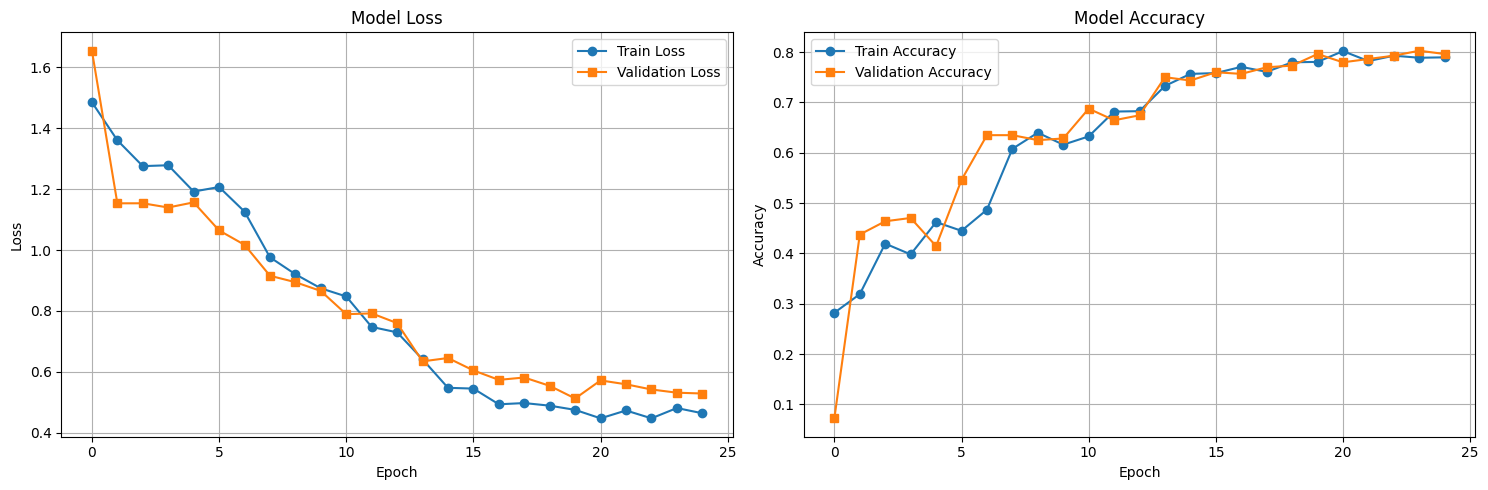

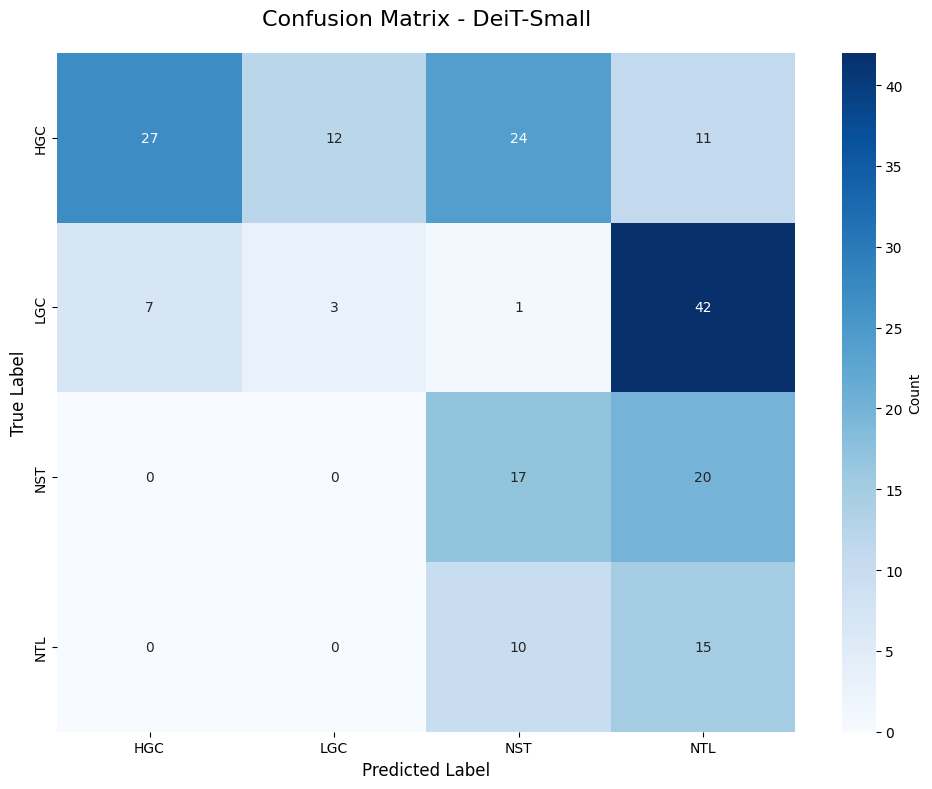

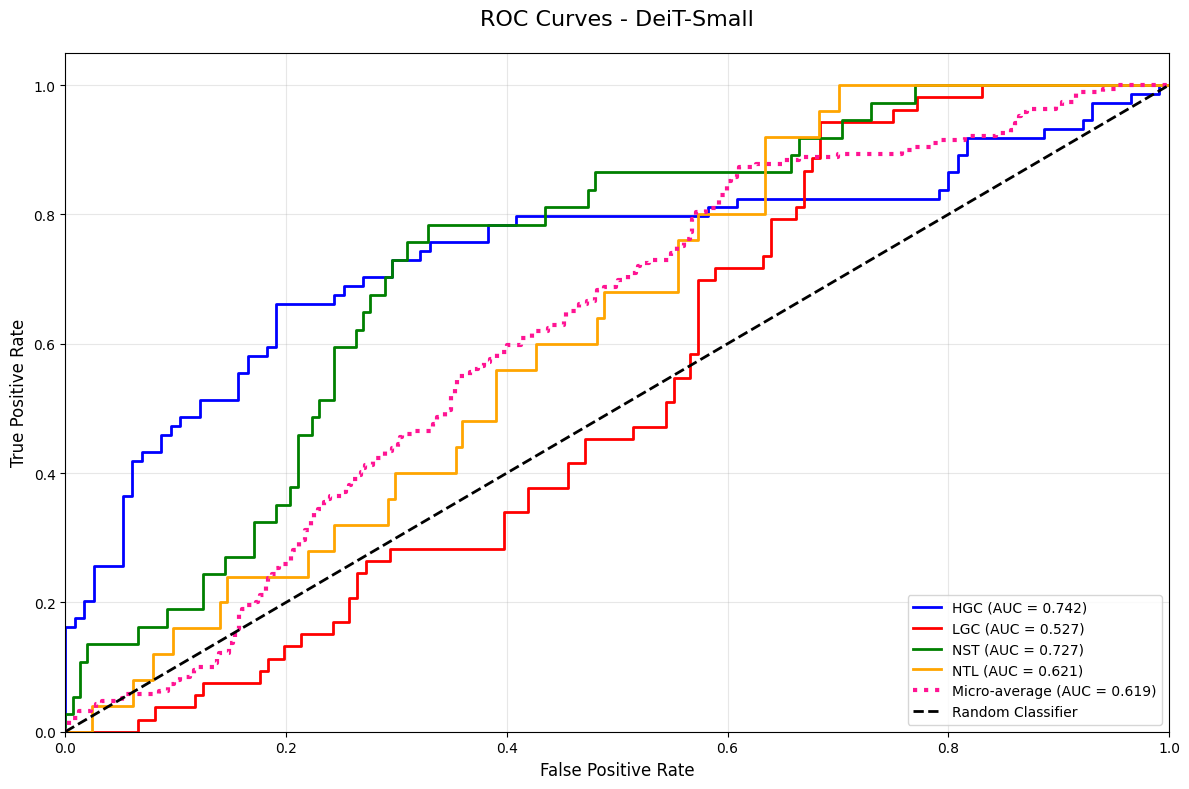


DeiT-Small training and evaluation complete!


In [17]:
print("=" * 80)
print("Training DeiT Small")
print("=" * 80)

# Create model
deit_small = create_deit_model(model_type='small', num_classes=4, pretrained=True)

# Create trainer
trainer_deit_small = ModelTrainer(deit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_small = trainer_deit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Small")

# Plot training history
trainer_deit_small.plot_training_history(save_path='deit_small_training_history.png')

# Evaluate model
results_deit_small = trainer_deit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_small['confusion_matrix'], class_names, 'DeiT-Small',
                      save_path='deit_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_small = plot_roc_curves(results_deit_small['labels'], results_deit_small['probabilities'], class_names, 'DeiT-Small',
                                     save_path='deit_small_roc_curves.png')

# Store results
results_deit_small['model_name'] = 'DeiT-Small'
results_deit_small['roc_auc'] = roc_auc_deit_small
all_results.append(results_deit_small)

print("\nDeiT-Small training and evaluation complete!")

## Train DeiT Small

## Train DeiT Base

Training DeiT Base


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.4933, Acc=0.3010]


Train Loss: 1.4933 Acc: 0.3010 Macro-F1: 0.2664


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=1.5464, Acc=0.2895]


Val Loss: 1.5464 Acc: 0.2895 Macro-F1: 0.1770
✓ New best model saved with validation macro-F1: 0.1770

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.3900, Acc=0.3026]


Train Loss: 1.3900 Acc: 0.3026 Macro-F1: 0.2816


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=1.3347, Acc=0.3684]


Val Loss: 1.3347 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.3135, Acc=0.3923]


Train Loss: 1.3135 Acc: 0.3923 Macro-F1: 0.3565


Val : 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, Loss=1.2928, Acc=0.4079]


Val Loss: 1.2928 Acc: 0.4079 Macro-F1: 0.3015
✓ New best model saved with validation macro-F1: 0.3015

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.2319, Acc=0.4638]


Train Loss: 1.2319 Acc: 0.4638 Macro-F1: 0.4214


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=1.0543, Acc=0.6053]


Val Loss: 1.0543 Acc: 0.6053 Macro-F1: 0.4778
✓ New best model saved with validation macro-F1: 0.4778

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.2553, Acc=0.5502]


Train Loss: 1.2553 Acc: 0.5502 Macro-F1: 0.4552


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.9889, Acc=0.6184]


Val Loss: 0.9889 Acc: 0.6184 Macro-F1: 0.5309
✓ New best model saved with validation macro-F1: 0.5309

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.1405, Acc=0.5765]


Train Loss: 1.1405 Acc: 0.5765 Macro-F1: 0.5040


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=1.0176, Acc=0.6480]


Val Loss: 1.0176 Acc: 0.6480 Macro-F1: 0.5647
✓ New best model saved with validation macro-F1: 0.5647

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.0355, Acc=0.6464]


Train Loss: 1.0355 Acc: 0.6464 Macro-F1: 0.5658


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=1.5136, Acc=0.3651]


Val Loss: 1.5136 Acc: 0.3651 Macro-F1: 0.2789

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.9419, Acc=0.6439]


Train Loss: 0.9419 Acc: 0.6439 Macro-F1: 0.5801


Val : 100%|██████████| 10/10 [00:02<00:00,  4.34it/s, Loss=0.8329, Acc=0.6842]


Val Loss: 0.8329 Acc: 0.6842 Macro-F1: 0.6268
✓ New best model saved with validation macro-F1: 0.6268

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.7943, Acc=0.7410]


Train Loss: 0.7943 Acc: 0.7410 Macro-F1: 0.6610


Val : 100%|██████████| 10/10 [00:02<00:00,  4.34it/s, Loss=0.7685, Acc=0.7039]


Val Loss: 0.7685 Acc: 0.7039 Macro-F1: 0.6661
✓ New best model saved with validation macro-F1: 0.6661

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.7015, Acc=0.7673]


Train Loss: 0.7015 Acc: 0.7673 Macro-F1: 0.7142


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=0.7920, Acc=0.7138]


Val Loss: 0.7920 Acc: 0.7138 Macro-F1: 0.6874
✓ New best model saved with validation macro-F1: 0.6874

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6748, Acc=0.7780]


Train Loss: 0.6748 Acc: 0.7780 Macro-F1: 0.7251


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.5877, Acc=0.7961]


Val Loss: 0.5877 Acc: 0.7961 Macro-F1: 0.7601
✓ New best model saved with validation macro-F1: 0.7601

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6068, Acc=0.7854]


Train Loss: 0.6068 Acc: 0.7854 Macro-F1: 0.7480


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.5029, Acc=0.8454]


Val Loss: 0.5029 Acc: 0.8454 Macro-F1: 0.8258
✓ New best model saved with validation macro-F1: 0.8258

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.5413, Acc=0.8347]


Train Loss: 0.5413 Acc: 0.8347 Macro-F1: 0.8027


Val : 100%|██████████| 10/10 [00:02<00:00,  4.34it/s, Loss=0.4678, Acc=0.8618]


Val Loss: 0.4678 Acc: 0.8618 Macro-F1: 0.8446
✓ New best model saved with validation macro-F1: 0.8446

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4949, Acc=0.8413]


Train Loss: 0.4949 Acc: 0.8413 Macro-F1: 0.8026


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.4238, Acc=0.8651]


Val Loss: 0.4238 Acc: 0.8651 Macro-F1: 0.8492
✓ New best model saved with validation macro-F1: 0.8492

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3862, Acc=0.8824]


Train Loss: 0.3862 Acc: 0.8824 Macro-F1: 0.8638


Val : 100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Loss=0.4082, Acc=0.8684]


Val Loss: 0.4082 Acc: 0.8684 Macro-F1: 0.8456

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3831, Acc=0.8816]


Train Loss: 0.3831 Acc: 0.8816 Macro-F1: 0.8639


Val : 100%|██████████| 10/10 [00:02<00:00,  4.26it/s, Loss=0.3753, Acc=0.8849]


Val Loss: 0.3753 Acc: 0.8849 Macro-F1: 0.8647
✓ New best model saved with validation macro-F1: 0.8647

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.3577, Acc=0.8882]


Train Loss: 0.3577 Acc: 0.8882 Macro-F1: 0.8697


Val : 100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Loss=0.3372, Acc=0.8947]


Val Loss: 0.3372 Acc: 0.8947 Macro-F1: 0.8757
✓ New best model saved with validation macro-F1: 0.8757

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3526, Acc=0.8857]


Train Loss: 0.3526 Acc: 0.8857 Macro-F1: 0.8660


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.3450, Acc=0.8914]


Val Loss: 0.3450 Acc: 0.8914 Macro-F1: 0.8769
✓ New best model saved with validation macro-F1: 0.8769

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.3207, Acc=0.8980]


Train Loss: 0.3207 Acc: 0.8980 Macro-F1: 0.8844


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=0.3699, Acc=0.8783]


Val Loss: 0.3699 Acc: 0.8783 Macro-F1: 0.8532

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.3463, Acc=0.8906]


Train Loss: 0.3463 Acc: 0.8906 Macro-F1: 0.8693


Val : 100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Loss=0.3806, Acc=0.8816]


Val Loss: 0.3806 Acc: 0.8816 Macro-F1: 0.8559

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3037, Acc=0.9062]


Train Loss: 0.3037 Acc: 0.9062 Macro-F1: 0.8938


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=0.3059, Acc=0.9013]


Val Loss: 0.3059 Acc: 0.9013 Macro-F1: 0.8828
✓ New best model saved with validation macro-F1: 0.8828

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.3034, Acc=0.9038]


Train Loss: 0.3034 Acc: 0.9038 Macro-F1: 0.8915


Val : 100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Loss=0.3194, Acc=0.9013]


Val Loss: 0.3194 Acc: 0.9013 Macro-F1: 0.8828

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3193, Acc=0.9071]


Train Loss: 0.3193 Acc: 0.9071 Macro-F1: 0.8905


Val : 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, Loss=0.3305, Acc=0.8882]


Val Loss: 0.3305 Acc: 0.8882 Macro-F1: 0.8727

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3171, Acc=0.9005]


Train Loss: 0.3171 Acc: 0.9005 Macro-F1: 0.8869


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.3296, Acc=0.8914]


Val Loss: 0.3296 Acc: 0.8914 Macro-F1: 0.8752

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.3163, Acc=0.9071]


Train Loss: 0.3163 Acc: 0.9071 Macro-F1: 0.8917


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.3291, Acc=0.8882]


Val Loss: 0.3291 Acc: 0.8882 Macro-F1: 0.8727

Training complete in 10m 59s
Best validation macro-F1: 0.8828
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Test Accuracy: 40.21%
Test Loss: 2.0832

Classification Report:
              precision    recall  f1-score   support

         HGC       0.56      0.47      0.51        74
         LGC       0.30      0.13      0.18        53
         NST       0.43      0.49      0.46        37
         NTL       0.26      0.64      0.37        25

    accuracy                           0.40       189
   macro avg       0.39      0.43      0.38       189
weighted avg       0.42      0.40      0.39       189


Confusion Matrix:
[[35 14 18  7]
 [21  7  0 25]
 [ 4  1 18 14]
 [ 2  1  6 16]]

ROC-AUC Scores:
Macro-average AUC: 0.6806
Micro-average AUC: 0.6521
HGC AUC: 0.7027
LGC AUC: 0.4888
NST AUC: 0.7683
NTL AUC: 0.7627


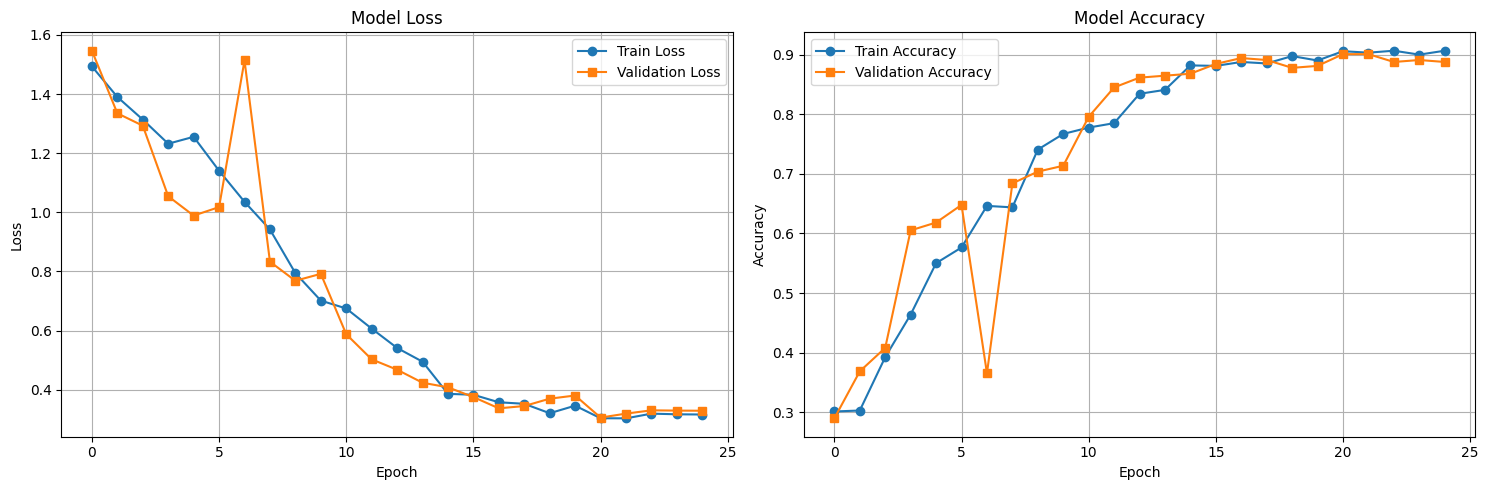

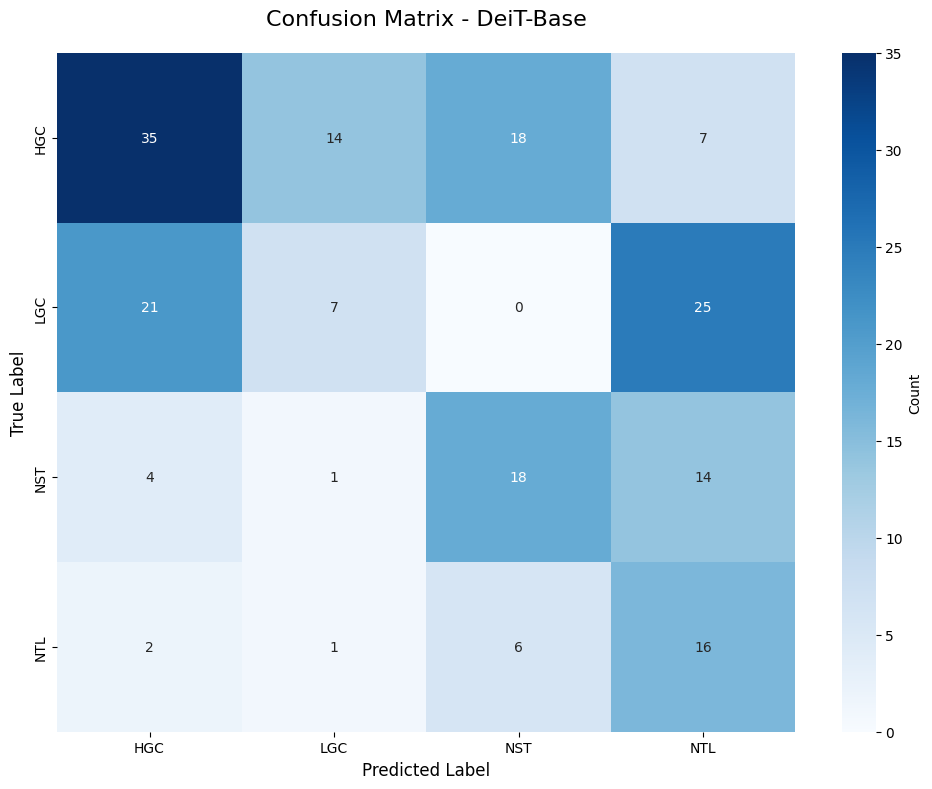

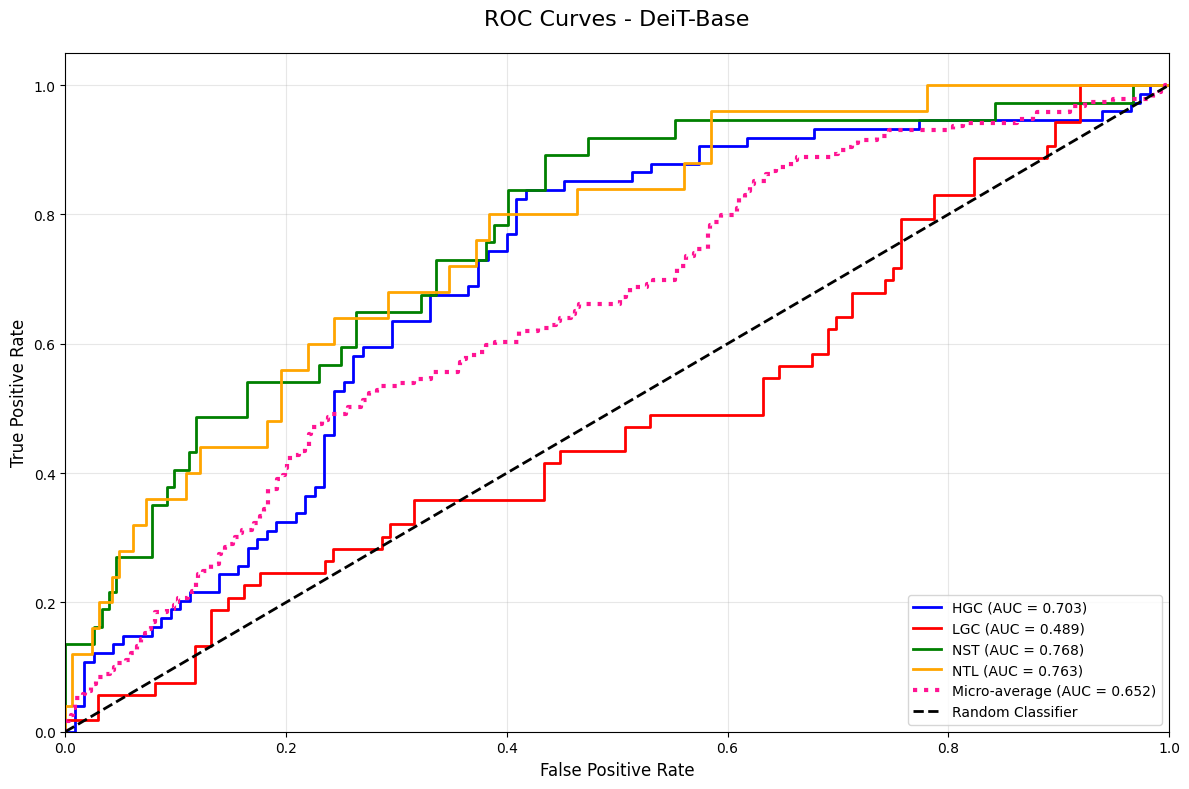


DeiT-Base training and evaluation complete!


In [18]:
print("=" * 80)
print("Training DeiT Base")
print("=" * 80)

# Create model
deit_base = create_deit_model(model_type='base', num_classes=4, pretrained=True)

# Create trainer
trainer_deit_base = ModelTrainer(deit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_base = trainer_deit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Base")

# Plot training history
trainer_deit_base.plot_training_history(save_path='deit_base_training_history.png')

# Evaluate model
results_deit_base = trainer_deit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_base['confusion_matrix'], class_names, 'DeiT-Base',
                      save_path='deit_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_base = plot_roc_curves(results_deit_base['labels'], results_deit_base['probabilities'], class_names, 'DeiT-Base',
                                     save_path='deit_base_roc_curves.png')

# Store results
results_deit_base['model_name'] = 'DeiT-Base'
results_deit_base['roc_auc'] = roc_auc_deit_base
all_results.append(results_deit_base)

print("\nDeiT-Base training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'DeiT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: DeiT_metrics.csv

Metrics Summary:
        Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   DeiT-Tiny         35.449735      2.342730             0.339467          0.383585      0.333497                0.380839             0.354497         0.343522       0.560000    0.378378  0.451613         74.0       0.208333    0.094340  0.129870         53.0       0.396552    0.621622  0.484211         37.0       0.192982        0.44  0.268293         25.0   0.632671   0.623433  0.740306  0.346004  0.771693  0.672683      0.740306      0.346